# Autoencoder and Classification
Autoencoders are often used with images. While we humans see an image as a 2-D object with $m$ pixels in one direction and $n$ pixels in the other direction, for a computer an image is $m * n$ numbers where the order matters, because only then it can be interpreted as an image. This means that an image is a data point in a space with dimension $D = n * m$. Different images are different points in that space. A layer in a neural network maps this space to a different space, where those points representing images with similar content lie close together. If the neural network has several layers, then it is a sequence of mappings. The activation functions are intended to pull the data further apart after a linear mapping.

We illustrate this on the MNIST data set of handwritten digits (http://yann.lecun.com/exdb/mnist/).

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Load data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### Restrict data to a subset of digits

12665


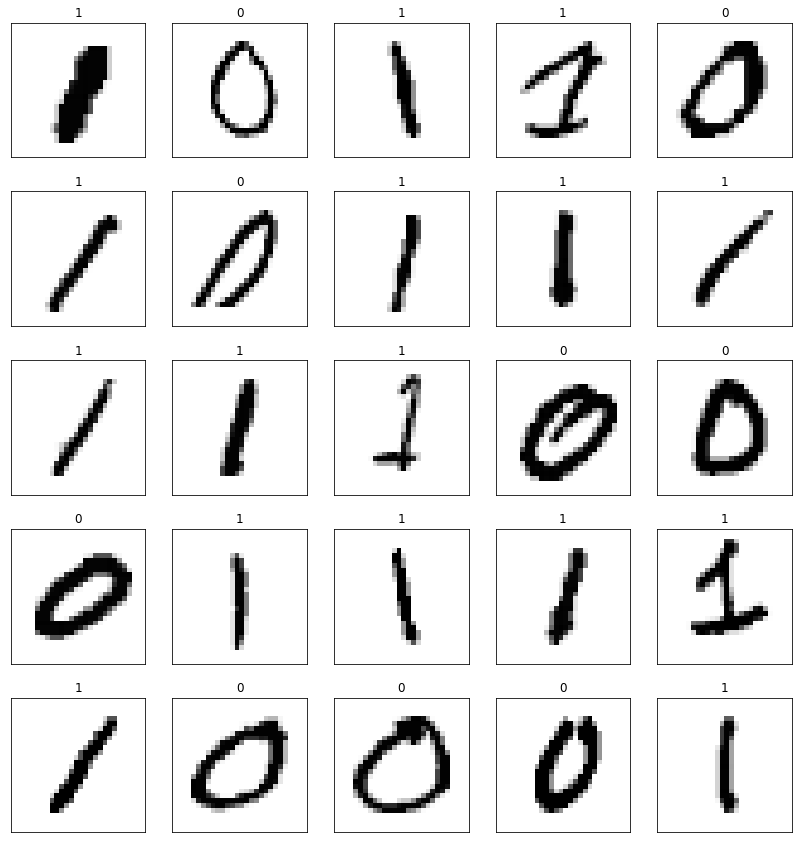

In [3]:
k = 1
data = x_train[y_train <=k]/255.0
data_label = y_train[y_train <=k]
print(data.shape[0])
choice = np.random.choice(np.arange(data.shape[0]),25)
rows = 5
cols = 5
fig = plt.figure(figsize=(14,rows*3))
for i in range(rows):
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i*cols+j+1)
        ax.imshow(data[choice[i*cols+j]], cmap='Greys')
        ax.title.set_text(data_label[choice[i*cols+j]])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

### Center the data by subtracting the mean
We will illustrate in teh analysis below, why this step is necessary.

(12665, 28, 28)


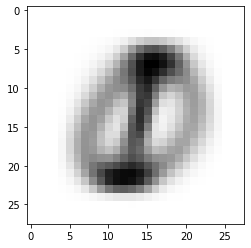

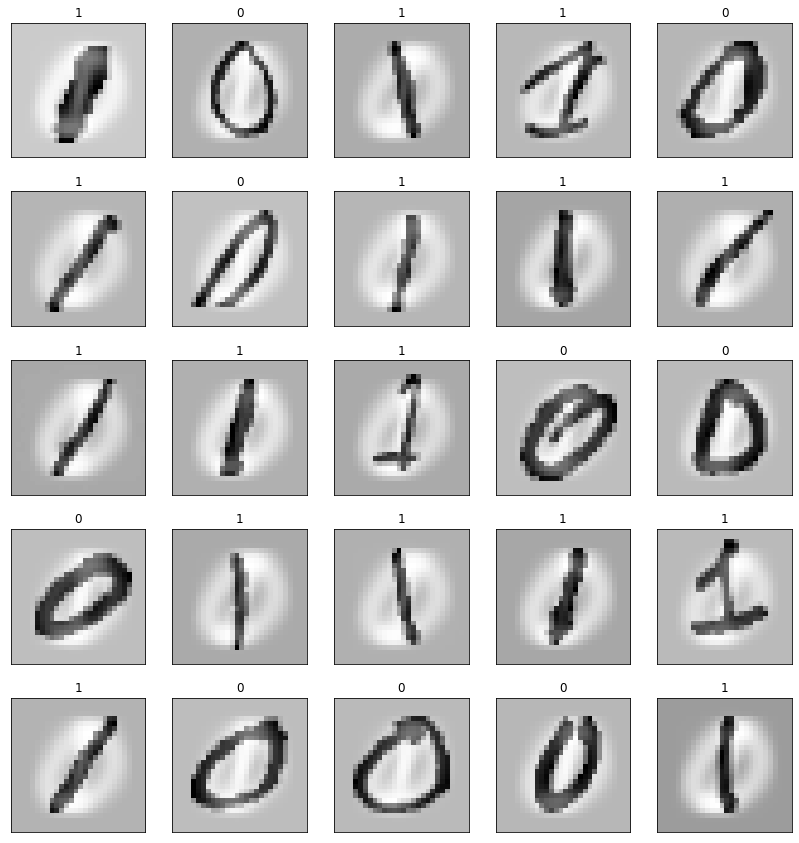

In [4]:
m = np.mean(data, axis = 0)
plt.imshow(m, cmap='Greys')
data_centered = np.array([data[i,:,:] - m for i in range(data.shape[0])])
print(data_centered.shape)
fig = plt.figure(figsize=(14,rows*3))
for i in range(rows):
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i*cols+j+1)
        ax.imshow(data_centered[choice[i*cols+j]], cmap='Greys')
        ax.title.set_text(data_label[choice[i*cols+j]])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

## Simple Autoencoder
Autoencoders are neural networks which aim to reconstruct the input. We illustrate this with a simple two layer autoencoder with $D$ input neurons and $D$ output neurons and $M$ neurons in the set of hidden neurons. The input is encoded from a space of dimension $D$ to one of dimension $M$ and then decoded bqack to $D$ dimensions. The question is, how small can $M$ be? It can be surprisingly small considering the large input dimension of an image. The bias is incorporated in dummy neurons which always have the value 1.

### Forward propagation
![alt text](Autoencoder.png "Autoencoder")

The activations of the hidden neurons are calculated as
\begin{equation}
\left( \begin{array}{c} a_1^{\textrm{IN}} \\ \vdots \\ a_M^{\textrm{IN}} \end{array} \right) = \left( \begin{array}{cccc} w_{11}^{\textrm{IN}} & \cdots & w_{1D}^{\textrm{IN}} & w_{1D+1}^{\textrm{IN}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{M1}^{\textrm{IN}} & \cdots & w_{MD}^{\textrm{IN}} & w_{MD+1}^{\textrm{IN}} \end{array} \right) \left( \begin{array}{c} x_1 \\ \vdots \\ x_D \\ 1 \end{array} \right).
\end{equation}
The latent variables in the hidden neurons are then
\begin{equation}
\left( \begin{array}{c} z_1 \\ \vdots \\ z_M \end{array} \right) = \left( \begin{array}{c} h(a_1^{\textrm{IN}}) \\ \vdots \\ h(a_M^{\textrm{IN}}) \end{array} \right),
\end{equation}
where $h$ is the activation function. The activation of the output neuron is
\begin{equation}
\left( \begin{array}{c} a_1^{\textrm{OUT}} \\ \vdots \\ a_D^{\textrm{OUT}} \end{array} \right) = \left( \begin{array}{cccc} w_{11}^{\textrm{OUT}} & \cdots & w_{1M}^{\textrm{OUT}} & w_{1M+1}^{\textrm{OUT}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{D1}^{\textrm{OUT}} & \cdots & w_{DM}^{\textrm{OUT}} & w_{DM+1}^{\textrm{OUT}} \end{array} \right) \left( \begin{array}{c} z_1 \\ \vdots \\ z_M \\ 1 \end{array} \right).
\end{equation}
and the output is calculated as
\begin{equation}
\left( \begin{array}{c} y_1 \\ \vdots \\ y_D \end{array} \right) = \left( \begin{array}{c} h(a_1^{\textrm{OUT}}) \\ \vdots \\ h(a_D^{\textrm{OUT}}) \end{array} \right),
\end{equation}

### Training
The reconstruction error is 
\begin{equation}
\left( \begin{array}{c} \delta_1^{\textrm{OUT}} \\ \vdots \\ \delta_D^{\textrm{OUT}} \end{array} \right) = \left( \begin{array}{c} y_1 \\ \vdots \\ y_D \end{array} \right) - \left( \begin{array}{c} x_1 \\ \vdots \\ x_D \end{array} \right).
\end{equation}
Training consists of minimizing a cost function $E$ which in this case is the squared reconstruction error across all training images. The negative gradient (derivative with respect to all weights) at a point on the cost function points in the direction of steepest descent. The minimization is performed by taking a step in this direction and adjusting the weights by this step. The step size is given by the learning rate $\eta$, too small and the convergence is slow, too large and we might overshoot the minimum.

### Backward error propagation

The reconstruction error gets propagated back to the hidden neurons by
\begin{equation}
\left( \begin{array}{c} \delta_1^{\textrm{IN}} \\ \vdots \\ \delta_M^{\textrm{IN}} \end{array} \right) = \left( \begin{array}{c} h'(a_1^{\textrm{IN}}) b_1 \\ \vdots \\ h'(a_M^{\textrm{IN}}) b_M \end{array} \right),
\end{equation}
where
\begin{equation}
\left( \begin{array}{c} b_1 \\ \vdots \\ b_M \end{array} \right) = \left( \begin{array}{ccc} w_{11}^{\textrm{OUT}} & \cdots & w_{D1}^{\textrm{OUT}} \\ \vdots & \ddots & \vdots \\ w_{1M}^{\textrm{OUT}} & \cdots & w_{DM}^{\textrm{OUT}} \end{array} \right) \left( \begin{array}{c} \delta_1^{\textrm{OUT}} \\ \vdots \\ \delta_D^{\textrm{OUT}} \end{array} \right)
\end{equation}


The derivatives of $E$ with respect to the weights are
\begin{equation}
\left( \begin{array}{cccc} \frac{\partial}{\partial w_{11}^{\textrm{OUT}}} & \cdots & \frac{\partial}{\partial w_{1M}^{\textrm{OUT}}} & \frac{\partial}{\partial w_{1M+1}^{\textrm{OUT}}} \\ \vdots & \ddots & \vdots & \vdots \\ \frac{\partial}{\partial w_{D1}^{\textrm{OUT}}} & \cdots & \frac{\partial}{\partial w_{DM}^{\textrm{OUT}}} & \frac{\partial}{\partial w_{DM+1}^{\textrm{OUT}}}\end{array} \right) E = \left( \begin{array}{c} \delta_1^{\textrm{OUT}} \\ \vdots \\ \delta_D^{\textrm{OUT}} \end{array} \right) \left( \begin{array}{cccc} z_1 & \cdots & z_M & 1 \end{array} \right)
\end{equation}
and 
\begin{equation}
\left( \begin{array}{cccc} \frac{\partial}{\partial w_{11}^{\textrm{IN}}} & \cdots & \frac{\partial}{\partial w_{1D}^{\textrm{IN}}} & \frac{\partial}{\partial w_{1D+1}^{\textrm{IN}}} \\ \vdots & \ddots & \vdots & \vdots \\ \frac{\partial}{\partial w_{M1}^{\textrm{IN}}} & \cdots & \frac{\partial}{\partial w_{MD}^{\textrm{IN}}} & \frac{\partial}{\partial w_{MD+1}^{\textrm{IN}}}\end{array} \right) E = \left( \begin{array}{c} \delta_1^{\textrm{IN}} \\ \vdots \\ \delta_M^{\textrm{IN}} \end{array} \right) \left( \begin{array}{cccc} x_1 & \cdots & x_D & 1 \end{array} \right).
\end{equation}

After seeing one training image, the weights are updated by
\begin{equation}
\left( \begin{array}{cccc} w_{11}^{\textrm{OUT}} & \cdots & w_{1M}^{\textrm{OUT}} & w_{1M+1}^{\textrm{OUT}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{D1}^{\textrm{OUT}} & \cdots & w_{DM}^{\textrm{OUT}} & w_{DM+1}^{\textrm{OUT}} \end{array} \right) = \left( \begin{array}{cccc} w_{11}^{\textrm{OUT}} & \cdots & w_{1M}^{\textrm{OUT}} & w_{1M+1}^{\textrm{OUT}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{D1}^{\textrm{OUT}} & \cdots & w_{DM}^{\textrm{OUT}} & w_{DM+1}^{\textrm{OUT}} \end{array} \right) -  \eta \left( \begin{array}{c} \delta_1^{\textrm{OUT}} \\ \vdots \\ \delta_D^{\textrm{OUT}} \end{array} \right) \left( \begin{array}{cccc} z_1 & \cdots & z_M & 1 \end{array} \right)
\end{equation}
and
\begin{equation}
\left( \begin{array}{cccc} w_{11}^{\textrm{IN}} & \cdots & w_{1D}^{\textrm{IN}} & w_{1D+1}^{\textrm{IN}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{M1}^{\textrm{IN}} & \cdots & w_{MD}^{\textrm{IN}} & w_{MD+1}^{\textrm{IN}} \end{array} \right)
 = \left( \begin{array}{cccc} w_{11}^{\textrm{IN}} & \cdots & w_{1D}^{\textrm{IN}} & w_{1D+1}^{\textrm{IN}} \\ \vdots & \ddots & \vdots & \vdots \\ w_{M1}^{\textrm{IN}} & \cdots & w_{MD}^{\textrm{IN}} & w_{MD+1}^{\textrm{IN}} \end{array} \right)
 -  \eta \left( \begin{array}{c} \delta_1^{\textrm{IN}} \\ \vdots \\ \delta_M^{\textrm{IN}} \end{array} \right) \left( \begin{array}{cccc} x_1 & \cdots & x_D & 1 \end{array} \right).
\end{equation}

Using one training sample at a time, is known as *online* or *sequential* learning. Updating in one step using several training samples is known as *batch* or *mini-batch* methods.

## Activation function
### Logistic sigmoid
The logistic sigmoid function is defined as
\begin{equation}
y = h(x) = \frac{1}{1+\exp(-x)} = \frac{\exp(x)}{\exp(x) +1}
\end{equation}
The derivative is
\begin{equation}
h'(x) = \frac{\exp(x)}{(\exp(x) +1)^2} = h(x) (1 - h(x)) = y(1-y)
\end{equation}
This will be used as activation function. Around zero is a transition zone between the two states. The size of the transition zone can be changed by multiplying $x$ by a positive number. The larger this number the faster the transition. 

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(y):
    return y * (1 - y)

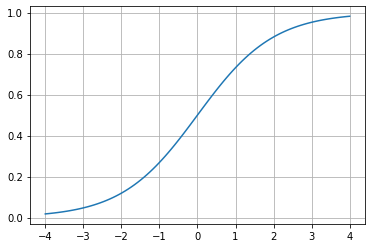

In [6]:
x = np.linspace(-4,4,100)
y = sigmoid(x)
fig = plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.show()

In [7]:
class NeuralNetwork:
    
    def __init__(self,
                 nin,     # number of input neurons
                 nout,    # number of output neurons
                 nhidden, # number of hidden neurons
                 tol,     #tolerance
                 nepoch,  # number of epochs
                 rate):   # learning rate
        self.nin = nin
        self.nout = nout
        self.nhidden = nhidden
        self.tol = tol
        self.nepoch = nepoch
        self.rate = rate 
        self.init_weights()
        
    def init_weights(self):  # He et al.(2015) initialization
        # + 1 is the bias neuron
        self.weights_in = np.random.randn(self.nhidden, self.nin+1) * np.sqrt(2/self.nin)
        self.weights_out = np.random.randn(self.nout, self.nhidden+1) * np.sqrt(2/self.nhidden)
        
    def predict(self, X): # X row vectors
        # Append bias and multiply with weights.
        self.A = self.weights_in @ np.append(X.T,np.ones((1,X.shape[0])), axis = 0)
        # Apply activation function to calculate latent variables.
        self.Z = sigmoid(self.A)
        # Append bias and multiply with weights.
        Y = sigmoid(self.weights_out @ np.append(self.Z,np.ones((1,self.Z.shape[1])), axis =0))
        return Y.T
    
    def train(self, X):
        # Permute the training data.
        perm = np.random.permutation(X.shape[0])
        # Append bias, multiply with weights and apply activation function.
        Z = sigmoid(self.weights_in @ np.append(X[perm,:].T,np.ones((1,X.shape[0])), axis = 0))
        Y = sigmoid(self.weights_out @ np.append(Z,np.ones((1,Z.shape[1])), axis =0))
        # Errors for all training samples.
        Y_errors = Y - X[perm].T
        cost = 0.5 * np.sum(Y_errors**2)
        epoch = 0
        while cost > self.tol and epoch < self.nepoch:
            epoch = epoch+1
            # Propagate errors. 
            # Note first multiplication componentwise, second matrix multiplication.
            # Using special property of sigmoid derivative.
            Z_errors = sigmoid_derivative(Z) * (self.weights_out[:,:-1].T @ Y_errors)
            # Update weights in second layer.
            self.weights_out = self.weights_out - self.rate * Y_errors @ np.append(Z,np.ones((1,Z.shape[1])), axis =0).T
            # Update weights in first layer.
            self.weights_in = self.weights_in - self.rate * Z_errors @ np.append(X[perm,:],np.ones((X.shape[0],1)), axis = 1)
            # Permute the training data.
            perm = np.random.permutation(X.shape[0])
            # Append bias, multiply with weights and apply activation function.
            Z = sigmoid(self.weights_in @ np.append(X[perm,:].T,np.ones((1,X.shape[0])), axis = 0))
            Y = sigmoid(self.weights_out @ np.append(Z,np.ones((1,Z.shape[1])), axis =0))
            # Errors for all training samples.
            Y_errors = Y - X[perm].T
            cost = 0.5 * np.sum(Y_errors**2)
        print(cost)
        return epoch

## Reshape images into arrays

In [8]:
train = np.reshape(data_centered,(data_centered.shape[0],data_centered.shape[1]*data_centered.shape[2]))

## Initialize neural network
Run this code several times and note that each run produces a different function which is smooth. 

In [9]:
NN = NeuralNetwork(nin=train.shape[1], nout=train.shape[1], nhidden=2, tol = 0.1, nepoch=1000, rate=0.4)

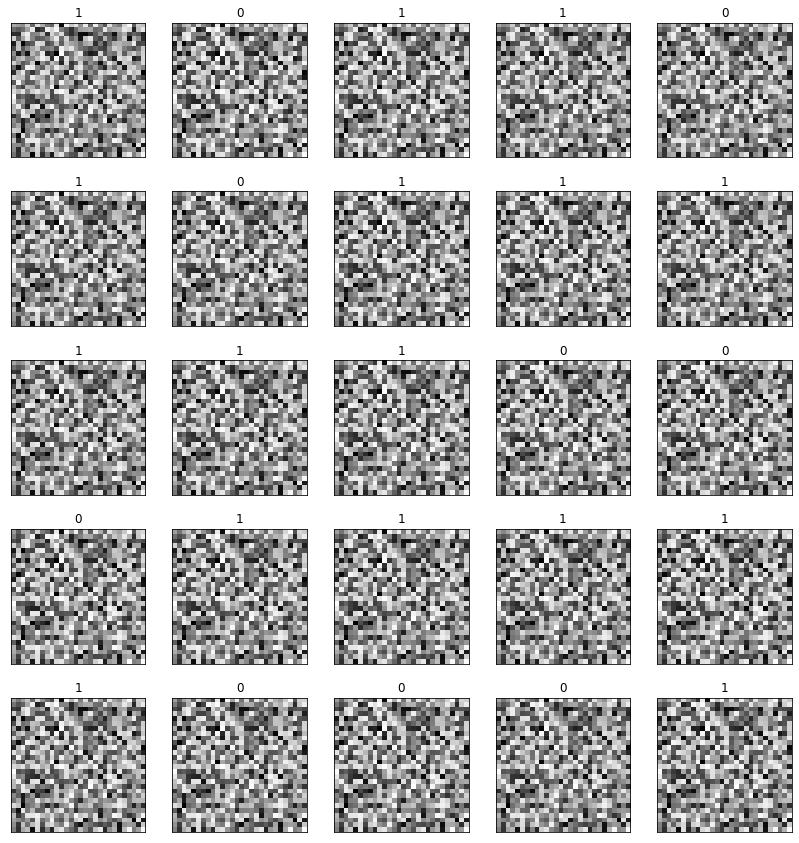

In [10]:
y = NN.predict(train[choice,:])
fig = plt.figure(figsize=(14,rows*3))
for i in range(rows):
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i*cols+j+1)
        ax.imshow(np.reshape(y[i*cols+j],(data.shape[1],data.shape[2])), cmap='Greys')
        ax.title.set_text(data_label[choice[i*cols+j]])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()
# print(NN.A)
# print(NN.Z)

## Train neural network
The performance of the training as well as the prediction depends on the random initialization of the neural network above, the number and distribution of training data samples, the learning rate, the convergence tolerance and number of epochs.

C:\Users\anfaul\.conda\envs\Test\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


527.7354141092737
Epochs until convergence: 1000


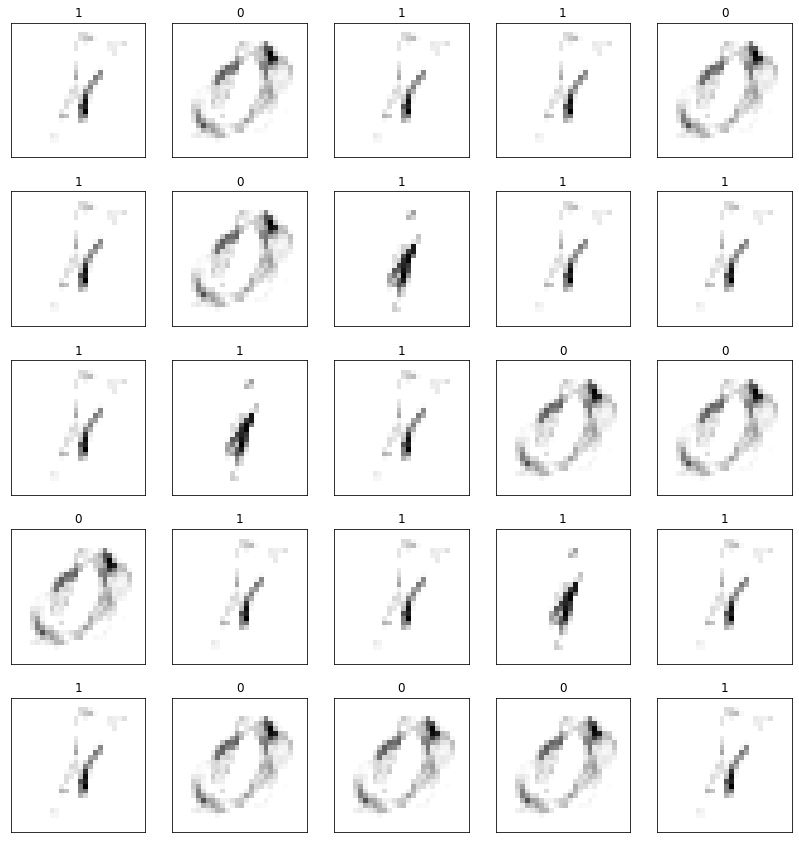

In [11]:
print('Epochs until convergence:', NN.train(train[choice,:]))
y = NN.predict(train[choice,:])
fig = plt.figure(figsize=(14,rows*3))
for i in range(rows):
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i*cols+j+1)
        ax.imshow(np.reshape(y[i*cols+j],(data.shape[1],data.shape[2])), cmap='Greys')
        ax.title.set_text(data_label[choice[i*cols+j]])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

## Building blocks
The predictions of the neural network are a linear combination of the latent variables in the hidden neurons. The synapses from those hidden neurons can therefore be interpreted as the bulding blocks building the model. We can visualize these building blocks by reshaping them into images. The last of these building blocks is the bias.

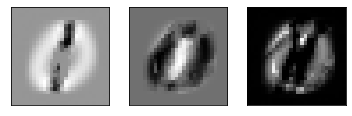

In [12]:
basis = np.array([np.reshape(NN.weights_out[:,i],(data.shape[1], data.shape[2])) for i in range(NN.weights_out.shape[-1])])
fig = plt.figure()
for i in range(basis.shape[0]):
    ax = fig.add_subplot(1, basis.shape[0], i+1)
    ax.imshow(basis[i], cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Spatial separation
The layer of hidden neurons specifies a low dimensional subspace. The number of dimensions is given by the number of hidden neurons. The latent variables give the coordinates of the data mapped to this subspace.We can check whether the neural network separates the data in this subspace by plotting the coordinates. 

C:\Users\anfaul\.conda\envs\Test\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


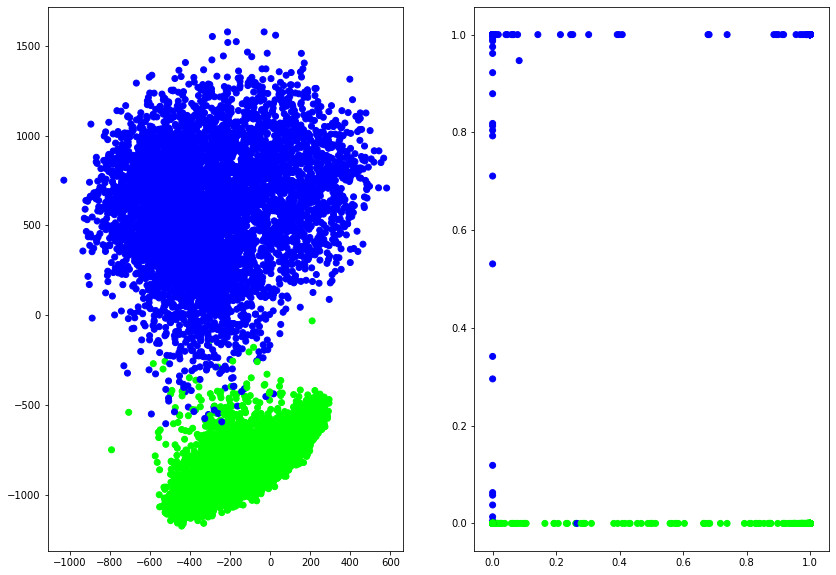

In [15]:
NN.predict(train)
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(NN.A[0,:],NN.A[1,:], c = data_label, cmap = plt.cm.brg)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(NN.Z[0,:],NN.Z[1,:], c = data_label, cmap = plt.cm.brg)
plt.show()

### Size and distribution of weights
Another indication to indicate trouble with the network is the distribution of positive and negative weights. Many regularization techniques for neural networks are concerned with controlling the distribution of weights. 

In [16]:
print(NN.weights_in[NN.weights_in<0].size, 'negative weights with average weight;', sum(NN.weights_in[NN.weights_in<0])/NN.weights_in[NN.weights_in<0].size)
print(NN.weights_in[NN.weights_in>0].size, 'positive weights with average weight;', sum(NN.weights_in[NN.weights_in>0])/NN.weights_in[NN.weights_in>0].size)

620 negative weights with average weight; -5.463566725809396
950 positive weights with average weight; 4.227042180988302


## When things go wrong
Let's use the uncentered data.

C:\Users\anfaul\.conda\envs\Test\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


736.2306789640616
Epochs until convergence: 1000


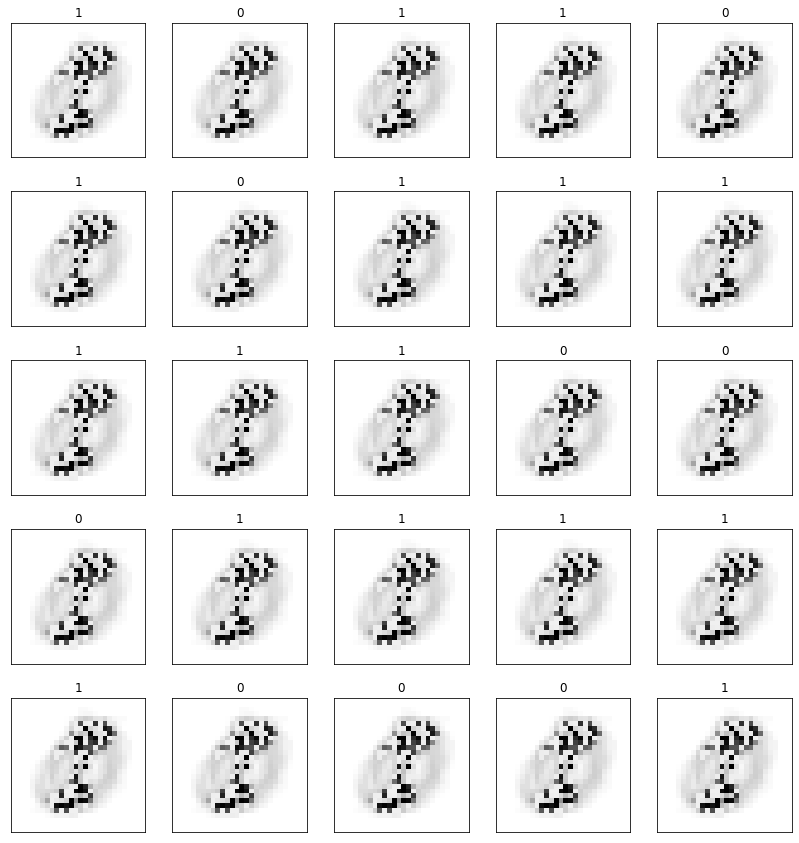

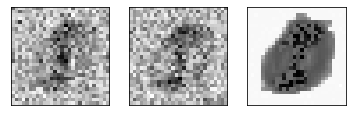

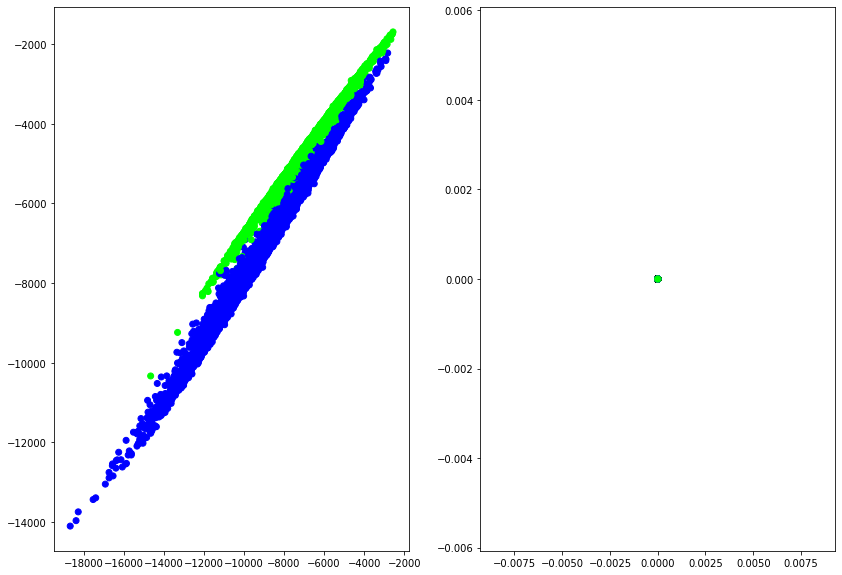

1171 negative weights with average weight; -31.60485030742616
399 positive weights with average weight; 0.03961248403695555


In [18]:
train = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]))
NN = NeuralNetwork(nin=train.shape[1], nout=train.shape[1], nhidden=2, tol = 0.1, nepoch=1000, rate=0.4)
print('Epochs until convergence:', NN.train(train[choice,:]))
y = NN.predict(train[choice,:])
fig = plt.figure(figsize=(14,rows*3))
for i in range(rows):
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i*cols+j+1)
        ax.imshow(np.reshape(y[i*cols+j],(data.shape[1],data.shape[2])), cmap='Greys')
        ax.title.set_text(data_label[choice[i*cols+j]])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()
basis = np.array([np.reshape(NN.weights_out[:,i],(data.shape[1], data.shape[2])) for i in range(NN.weights_out.shape[-1])])
fig = plt.figure()
for i in range(basis.shape[0]):
    ax = fig.add_subplot(1, basis.shape[0], i+1)
    ax.imshow(basis[i], cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
NN.predict(train)
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(NN.A[0,:],NN.A[1,:], c = data_label, cmap = plt.cm.brg)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(NN.Z[0,:],NN.Z[1,:], c = data_label, cmap = plt.cm.brg)
plt.show()
print(NN.weights_in[NN.weights_in<0].size, 'negative weights with average weight;', sum(NN.weights_in[NN.weights_in<0])/NN.weights_in[NN.weights_in<0].size)
print(NN.weights_in[NN.weights_in>0].size, 'positive weights with average weight;', sum(NN.weights_in[NN.weights_in>0])/NN.weights_in[NN.weights_in>0].size)

**We see that the neural network learns the avaerage of the data in the bias and considers the bias a good enough representation of all data failing miserably in the reconstruction. The latent variables are all close to zero. The high number of negative weights and also the relative size of the negative weights compared to the positive weights indicate that activitations are mapped to zero. The neural network has learned no distinguishing features between the two classes.**